In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import os
import datetime as dt
# import scipy.stats as stats
# from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm
import alphalens as al
import pickle
import warnings
import json

# from functions.datareader import pull_stock_data, YFinanceReader
# from functions.portfolio_optimizer import RiskModelPCA, OptimalHoldings, OptimalHoldingsStrictFactor
from functions.alpha_evaluator import AlphaFactorEvaluator
from functions.alpha_generator import NoOverlapClassifier
from functions.indicators import TechnicalIndicators

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [126]:
# define all parameters
START_DATE = dt.date(2015, 1, 1)
ADD_CASH = True

<h1 style="color:turquoise">Load data from local</h1>

In [127]:
# sectors
with open('./keys/set_sectors.json') as f:
    sectors = json.load(f)

In [128]:
# price data
raw_df = pd.read_parquet('./data/set')

raw_df.set_index(pd.DatetimeIndex(raw_df.index))
raw_df.index.name = 'date'
raw_df.tail(2)

,ticker,close,dividends,high,low,open,stock splits,volume
date,,,,,,,,
2023-08-23,WHA,5.2,0.0,5.30,5.15,5.3,0.0,63217700.0
2023-08-24,WHA,5.2,0.0,5.25,5.15,5.2,0.0,17078091.0


In [129]:
# map sector using the sector dict above
vk = [(k, v) for k, v in sectors.items()]
sector_mapper = {sub: s[0]for s in vk for sub in s[1]}
raw_df['sector'] = raw_df['ticker'].map(sector_mapper)

In [130]:
# filter only stocks that exist since our start date
first_date_df = raw_df[['ticker']].reset_index().groupby('ticker').min()
first_date_df['is_available_since_start'] = first_date_df['date'].apply(lambda x: True if x <= START_DATE else False)

available_tickers = first_date_df[first_date_df['is_available_since_start'] == True].reset_index()['ticker']

# create a sector_mapper of available stocks
sector_mapper_available = {s:sector_mapper[s] for s in sector_mapper if s in available_tickers.values}

# filter only selected stocks
selected_df = raw_df.reset_index().merge(available_tickers, left_on = 'ticker', right_on = 'ticker').set_index('date')

In [131]:
# if add cash, append rows of cash representative for the given dates
if ADD_CASH:
    cash_df = pd.DataFrame(index=selected_df.index.unique().sort_values(), columns=selected_df.columns)
    cash_df['ticker'] = 'cash'
    cash_df['sector'] = 'cash'
    cash_df['volume'] = 1e12 # ? assume infinite volume
    for c in ['open', 'high', 'low', 'close']:
        cash_df[c] = 1.0
    selected_df = selected_df.append(cash_df)

# create an OHLCV df in order to calculate technical indicators
ohlcv_df = selected_df[['ticker', 'open', 'high', 'low', 'close', 'volume']]

# create a dataframe of close price
close_df = selected_df[['ticker', 'sector', 'close']]
# create a wide (pivoted) dataframe of close price
close_df_pivot = close_df.pivot(columns = 'ticker', values = 'close')

In [132]:
selected_df.tail()

,ticker,close,dividends,high,low,open,stock splits,volume,sector
date,,,,,,,,,
2023-08-18,cash,1.0,NaN,1.0,1.0,1.0,NaN,1.000000e+12,cash
2023-08-21,cash,1.0,NaN,1.0,1.0,1.0,NaN,1.000000e+12,cash
2023-08-22,cash,1.0,NaN,1.0,1.0,1.0,NaN,1.000000e+12,cash
2023-08-23,cash,1.0,NaN,1.0,1.0,1.0,NaN,1.000000e+12,cash
2023-08-24,cash,1.0,NaN,1.0,1.0,1.0,NaN,1.000000e+12,cash


<h1 style="color:turquoise">Prepare data</h1>

<h3>Technical Indicators</h3>

In [133]:
ti_df = pd.DataFrame()

# * split multi-index dataframe to a dict of which each value represents OHLCV of each stock
for ticker in available_tickers.values:
    ticker_df = ohlcv_df[ohlcv_df['ticker'] == ticker].drop('ticker', axis = 1)
    
    ti = TechnicalIndicators(ticker_df)
    res_dict = dict()
    res_dict['rsi'] = ti.RSI(n=14)
    res_dict['stochastic_rsi_k'], res_dict['stochastic_rsi_d'] = ti.stochasticRSI(n=14, d=3)
    res_dict['macd'], res_dict['macd_signal'] = ti.MACD(n_long=26, n_short=12)
    res_dict['vol_change_pct'] = ti.volume_change_pct()
    res_dict['overnight_return'] = ti.overnight_return()
    res_dict['cv_ratio'] = ti.candlestick_volume_ratio(mode='whisker')
    res_dict['bollinger_ratio'] = ti.bollinger_ratio(n=20, k=2)
    res_df = pd.DataFrame.from_dict(res_dict).reset_index()
    res_df.insert(1, 'ticker', ticker)

    ti_df = ti_df.append(res_df, ignore_index = True)

# * filter date
ti_df = ti_df[ti_df['date'].dt.date >= START_DATE] \
            .set_index(['date', 'ticker'])


In [134]:
ti_df.tail(3)

,,rsi,stochastic_rsi_k,stochastic_rsi_d,macd,macd_signal,vol_change_pct,overnight_return,cv_ratio,bollinger_ratio
date,ticker,,,,,,,,,
2023-08-22,WHA,75.0,1.0,0.920813,0.085815,0.064976,-0.179492,0.009709,1.172827e-09,1.170316
2023-08-23,WHA,90.0,1.0,0.991878,0.096201,0.071221,-0.424778,0.019231,2.372755e-09,1.045195
2023-08-24,WHA,90.0,1.0,1.000000,0.103242,0.077625,-0.849281,0.000000,5.855450e-09,0.963857


In [137]:
# # TODO: save technical indicators
# ti_df.to_parquet('./data/features/set/technical_indicators.parquet')

# TODO: load data
# ti_df = pd.read_parquet('./data/features/set/technical_indicators.parquet')

<h3>Trailing 5-Day Return</h3>

In [240]:
N_FORWARD = 5
return_col_name = f'forward_return_{N_FORWARD}_day'
daily_return_df = close_df.pivot(columns = 'ticker', values = 'close').pct_change(N_FORWARD).shift(-N_FORWARD).mul(100)

# * filter date
daily_return_df = daily_return_df[daily_return_df.index.date >= START_DATE].dropna(axis = 0)

# * melt processed dataframe
daily_return_df = pd.melt(daily_return_df.reset_index(), id_vars='date', value_name=return_col_name, var_name='ticker')
daily_return_df.set_index(['date', 'ticker'], inplace=True)

# TODO: create positive return flag
# we'll frame the problem to be a classification problem with y equals 1 when a stock has positive forward return and 0 otherwise.
daily_return_df[return_col_name] = daily_return_df[return_col_name].apply(lambda x: 1 if x > 0 else 0)
daily_return_df.tail()

,,forward_return_5_day
date,ticker,
2023-08-10,cash,0
2023-08-11,cash,0
2023-08-15,cash,0
2023-08-16,cash,0
2023-08-17,cash,0


In [241]:
# TODO: combine x and y
df = ti_df.merge(daily_return_df, left_index=True, right_index=True, how='left')

# * map sector
sector_inversed = {v:k for k in sectors for v in sectors[k]}
df['sector'] = df.index.get_level_values(1).map(sector_inversed)

In [242]:
df[df['forward_return_5_day'].isnull()].index.get_level_values(0).unique()

DatetimeIndex(['2023-08-18', '2023-08-21', '2023-08-22', '2023-08-23',
               '2023-08-24'],
              dtype='datetime64[ns]', name='date', freq=None)

<h2>One-Hot Encode Sector</h2>

In [243]:
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [244]:
ohe = OneHotEncoder()
ohe.fit(df[['sector']])
sector_dummy = pd.DataFrame(ohe.transform(df[['sector']]).toarray(), columns=ohe.get_feature_names_out(), index=df.index)

In [245]:
df = df.merge(sector_dummy, left_index=True, right_index=True).drop('sector', axis = 1)

# * create month and day of week factors
df['month'] = df.index.get_level_values(0).month
df['day_of_week'] = df.index.get_level_values(0).dayofweek

In [246]:
# # TODO: split data
predict_df = df[df[return_col_name].isnull()]
df = df[~df[return_col_name].isnull()]

TRAIN_SIZE = 0.8
dates = sorted(df.index.get_level_values(0).unique())
n_data = len(dates)
train_split = int(TRAIN_SIZE * n_data)
train_dates = dates[:train_split]
test_dates = dates[train_split:]
split_date = train_dates[-1]

x_train = df[df.index.isin(train_dates, level=0)]
x_test = df[df.index.isin(test_dates, level=0)]

y_train = x_train.pop(return_col_name)
y_test = x_test.pop(return_col_name)

In [188]:
# Create a LightGBM object
lgb_model = LGBMClassifier()

# Specify the parameter grid to search over
param_grid = {'n_estimators': [20, 40, 60],
              'max_depth': [2, 5, 8],
              'min_child_samples': [500, 2000],
              'learning_rate': [1e-4, 1e-3],
              'num_leaves': [50, 100, 500],
              'colsample_bytree': [0.25, 0.5, 0.75],
              'subsample': [0.6, 0.8]}

# Create a time-series aware cross-validator
cv = TimeSeriesSplit(n_splits=5)

# Create a GridSearchCV object with the specified parameters
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=cv)

# Fit the grid search object to the data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.25, 0.5, 0.75],
                         'learning_rate': [0.0001, 0.001],
                         'max_depth': [2, 5, 8],
                         'min_child_samples': [500, 2000],
                         'n_estimators': [20, 40, 60],
                         'num_leaves': [50, 100, 500],
                         'subsample': [0.6, 0.8]})

In [189]:
# # TODO: use the best param to train the entire training data
lgb_model = LGBMClassifier(**grid_search.best_params_)
lgb_model.fit(x_train, y_train)


LGBMClassifier(colsample_bytree=0.25, learning_rate=0.0001, max_depth=2,
               min_child_samples=500, n_estimators=20, num_leaves=50,
               subsample=0.6)

In [190]:
# # TODO: save model
with open(f'model/lgbmclassifier_{dt.date.today()}.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

In [191]:
# # TODO: get training and testing errors
y_train_pred = lgb_model.predict(x_train)
y_pred = lgb_model.predict(x_test)
mse_train = accuracy_score(y_train_pred, y_train)
mse_test = accuracy_score(y_pred, y_test)

print(f'Accuracy on training data: {mse_train:.4f}')
print(f'Accuracy on testing data: {mse_test:.4f}')

Accuracy on training data: 0.5335
Accuracy on testing data: 0.5367


In [192]:
# # * feature importance
importances = pd.Series(lgb_model.feature_importances_, index = lgb_model.feature_name_) \
                .sort_values(ascending=False)
importances

month                            28
cv_ratio                         15
vol_change_pct                   10
stochastic_rsi_k                  4
macd                              1
rsi                               0
sector_industrial                 0
sector_nan                        0
sector_utilities                  0
sector_real_estate                0
sector_petrochemistry             0
sector_material                   0
sector_insurance                  0
sector_infrastructure             0
sector_consumer_staple            0
sector_hotel                      0
sector_hospital                   0
sector_consumer_finance           0
sector_consumer_discretionary     0
sector_banking                    0
bollinger_ratio                   0
overnight_return                  0
macd_signal                       0
stochastic_rsi_d                  0
day_of_week                       0
dtype: int32

<h1 style="color:turquoise">Use RandomForest to generate an AI-based Alpha Factor</h1>

In [193]:
# copy best parameters from grid search
best_params = {
    'colsample_bytree': 0.25,
    'learning_rate': 1e-4,
    'max_depth': 2,
    'min_child_samples': 500,
    'n_estimators': 20, 
    'num_leaves': 50,
    'subsample': 0.6
}

In [194]:
for c in x_train:
    sum_null = x_train[c].isnull().sum()
    if sum_null > 0:
        print(f'{c}: {sum_null}')

In [195]:
n_stocks = len(sector_mapper_available)
n_days = len(x_train)

# # ? for random forest with oob_score
# parameters = {
#     'criterion': 'entropy',
#     'max_depth': 10,
#     'min_samples_leaf': 500,
#     'min_samples_split': 200,
#     'learning_rate': 0.01,
#     'oob_score': True,
#     'n_jobs': -1,
#     'random_state': 42}

# ? for LightGBM
# parameters = grid_search.best_params_
parameters = best_params
del parameters['n_estimators']
n_trees_l = range(5, 105, 5)

In [196]:
# # TODO: iterate over several number of estimators
scores = []
feature_importances = []

for n_trees in n_trees_l:
    # clf = RandomForestClassifier(n_trees, **parameters)
    clf = LGBMClassifier(
        n_estimators=n_trees,
        **parameters
    )
    clf.fit(x_train, y_train)
    # scores.append({
    #     'n_tree': n_trees,
    #     'train': clf.score(x_train, y_train.values),
    #     'valid': clf.score(x_test, y_test.values),
    #     'oob': clf.oob_score_
    # })
    scores.append({
        'n_tree': n_trees,
        'train': clf.score(x_train, y_train.values),
        'valid': clf.score(x_test, y_test.values)
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

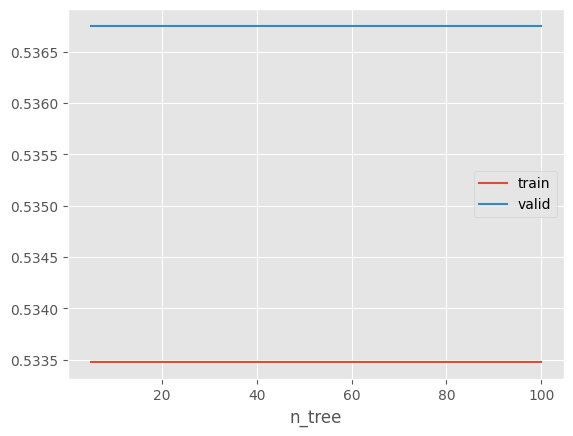

In [197]:
score_df.plot()
plt.legend(loc='best')

In [198]:
# # TODO: choose the best model from list
N = 20
# clf = RandomForestClassifier(N, **clf_parameters)
clf = LGBMClassifier(n_estimators=N, **parameters)
clf.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.25, learning_rate=0.0001, max_depth=2,
               min_child_samples=500, n_estimators=20, num_leaves=50,
               subsample=0.6)

In [199]:
prob_array = np.array([-1, 1])
proba = clf.predict_proba(x_train.append(x_test))

# calculate alpha score
# method 1
# alpha_score = proba.dot(prob_array)
# method 2
alpha_score = proba[:, 1]

# check classifier classes (the respective column names of predict_proba)
clf.classes_

array([0., 1.])

In [200]:
factors = ['rsi', 'bollinger_ratio', 'cv_ratio', 'macd_signal', 'macd']
alpha_score_label = 'AI_ALPHA'
factor_list = factors + [alpha_score_label]
# factors_with_alpha = df.loc[x_train.index].copy()
factors_with_alpha = df.copy()
factors_with_alpha[alpha_score_label] = alpha_score
selected_factor_df = factors_with_alpha[factor_list]
selected_factor_df.tail(3)

,,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,ticker,,,,,,
2023-08-15,WHA,40.0,0.244593,1.979778e-09,0.064993,0.045191,0.466519
2023-08-16,WHA,50.0,0.367064,1.593183e-09,0.060445,0.042252,0.466519
2023-08-17,WHA,50.0,0.663542,7.120375e-10,0.056888,0.042659,0.466524


In [201]:
alpha_eval = AlphaFactorEvaluator(factor_return=selected_factor_df, price=close_df_pivot)
factor_data_dict = alpha_eval.combine_factor_forward_returns(periods = (1, 5, 10), max_loss = 0.35, verbose = True)

Formatting factor data for rsi
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for bollinger_ratio
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for cv_ratio
Dropped 0.6% entries from factor data: 0.2% in forward returns computation and 0.4% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for macd_signal
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for macd
Dropped 0.2% entries from facto

In [202]:
factor_return_df = alpha_eval.get_factor_returns(
    factor_data_dict,
    demeaned=False,
    group_adjust=False,
    equal_weight=False
)

Text(0.5, 1.0, 'compared with the AI generated')

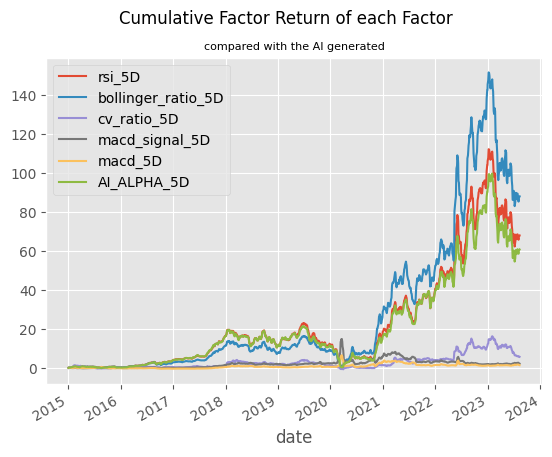

In [204]:
# # * period-wise return
# alpha = 0.6
# factor_return_df.plot(alpha = alpha)
# plt.legend()

# # * cumulative return
period = '5D'
period_col = [c for c in factor_return_df if period in c]
factor_return_df[period_col].add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

<AxesSubplot: xlabel='date'>

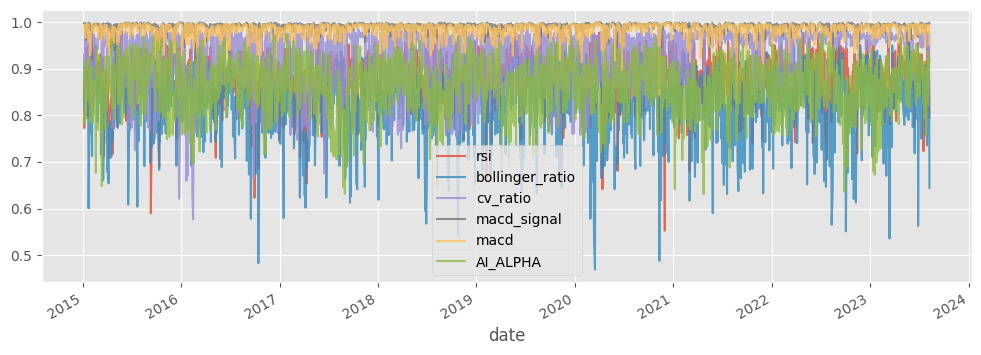

In [205]:
# Factor Rank Autocorrelation
rank_ac_df = alpha_eval.get_factor_rank_autocorrelation(factor_data_dict)
rank_ac_df.plot(alpha = 0.8, figsize = (12, 4))

<AxesSubplot: xlabel='factor_quantile'>

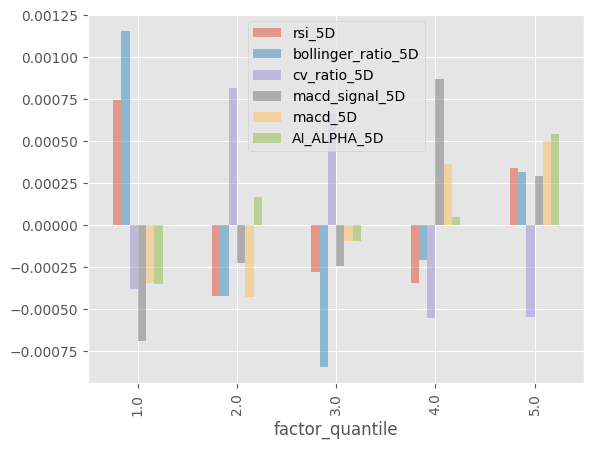

In [206]:
# mean return by quantile
qt_return_df = alpha_eval.get_mean_return_by_quantile(factor_data_dict)
period = '5D'
period_col = [c for c in factor_return_df if period in c]
qt_return_df[period_col].plot(kind='bar', alpha = 0.5)

In [207]:
# save factor_data
base_path = './test/alphalens/factor_data'
for factor_name, factor_df in factor_data_dict.items():
    factor_df.to_csv(f'{base_path}/factor_data_{factor_name}.csv')

# # load factor data
# factor_data_dict = dict()
# factor_list = []
# base_path = './test/alphalens/factor_data'
# for filename in os.listdir(base_path):
#     factor_name = filename.split('.')[0].replace('factor_data_', '')
#     factor_data_dict[factor_name] = pd.read_csv(f'{base_path}/{filename}', index_col=['date', 'asset'])
#     factor_list.append(factor_name)

In [208]:
# Get factor weight
factor_weight_list = []
for factor in factor_list:
    factor_weight = al.performance.factor_weights(
        factor_data=factor_data_dict[factor],
        demeaned=False,
        group_adjust=False,
        equal_weight=False
    ).to_frame()
    factor_weight.columns = [factor]
    factor_weight_list.append(factor_weight)

factor_weight_df = pd.concat(factor_weight_list, axis=1)
factor_weight_df.head(3)

,,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,asset,,,,,,
2015-01-05,AEONTS,0.015195,0.006341,0.018968,0.027876,-0.002990,0.018181
2015-01-06,AEONTS,0.014150,0.009510,0.030768,0.020589,-0.008418,0.018181
2015-01-07,AEONTS,0.008555,0.009278,0.031288,0.014273,-0.011438,0.018181


In [209]:
factor_weight_df.groupby(factor_weight_df.index.get_level_values(0)).sum().head(3)

,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,,,,,,
2015-01-05,1.0,0.996426,1.0,-0.609819,-0.778965,1.0
2015-01-06,1.0,0.970352,1.0,-0.657347,-0.833228,1.0
2015-01-07,1.0,1.000000,1.0,-0.697356,-0.838504,1.0


In [210]:
# Compute factor alpha and beta
res_list = []
for factor in selected_factor_df.columns:
    alpha_beta = al.performance.factor_alpha_beta(factor_data=factor_data_dict[factor])
    alpha_beta.columns = [f'{factor}_return_{c}' for c in alpha_beta.columns]
    res_list.append(alpha_beta)
alpha_beta_df = pd.concat(res_list, axis=1).T

In [211]:
alpha_beta_df

,Ann. alpha,beta
rsi_return_1D,-0.081366,-0.052836
rsi_return_5D,0.003769,-0.101486
rsi_return_10D,0.016121,-0.107599
bollinger_ratio_return_1D,-0.112220,-0.046632
bollinger_ratio_return_5D,0.007131,-0.083513
bollinger_ratio_return_10D,0.012607,-0.090456
cv_ratio_return_1D,-0.025523,-0.140383
cv_ratio_return_5D,-0.010397,-0.088168
cv_ratio_return_10D,-0.007185,-0.033607
macd_signal_return_1D,0.015612,-0.026251


In [212]:
# Quantile turnover
# quantile_turnover = al.performance.quantile_turnover(factor_data_dict['AI_ALPHA']['factor_quantile'], quantile=1, period=1)
# quantile_turnover.head(3)

quantile_turnover_dict = {}
for factor in factor_list:
    turnover_list = []
    for q in range(1, 6):
        quantile_turnover = al.performance.quantile_turnover(factor_data_dict[factor]['factor_quantile'], quantile=q, period=1) \
                                .to_frame()
        quantile_turnover.columns = [f'q{q}']
        turnover_list.append(quantile_turnover)
    turnover_df = pd.concat(turnover_list, axis=1) \
                    .dropna()
    quantile_turnover_dict[factor] = turnover_df

Text(0.5, 1.0, 'Quantile Turnover (rolling 5 period average) for factor: AI_ALPHA')

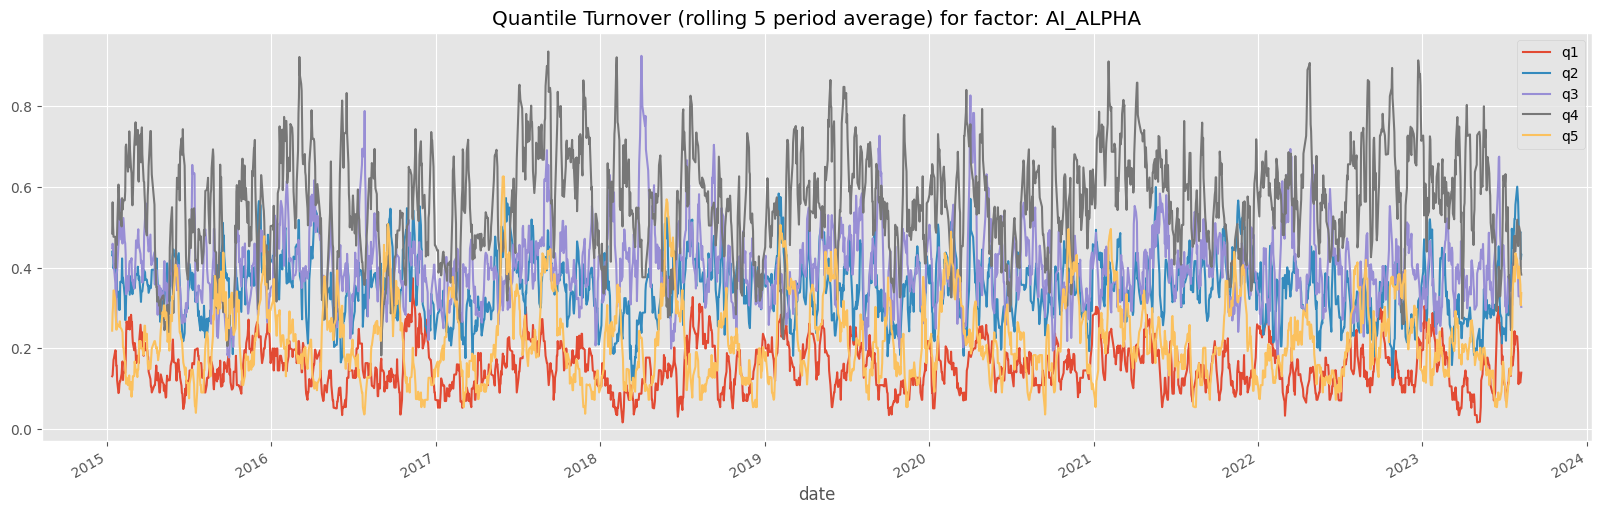

In [213]:
# visualize quantile turnover by factor
factor_name = 'AI_ALPHA'
n_rolling = 5
quantile_turnover_dict[factor_name].rolling(n_rolling).mean().plot(figsize=(20,6))
plt.title(f'Quantile Turnover (rolling {n_rolling} period average) for factor: {factor_name}')

<h1 style="color:turquoise">Filter factor by period-wise top rank</h1>
<p>Rationale is that we want to limit the number of invested assets in a given time period. Therefore, in a long-only portfolio, we will invest in only assets of which the factor values are in the top-tier</p>

In [214]:
TOP_N = 5
rank_df = selected_factor_df.copy()
flag_cols = []
rank_cols = []
for c in rank_df.columns:
    rank_df[f'period_rank_{c}'] = rank_df.groupby(rank_df.index.get_level_values(0))[c].rank(method='min', ascending=False)

    # ? add new factor name to selected columns with flag that the asset is selected
    select_flag_name = f'is_selected_{c}_top_{TOP_N}'
    flag_cols.append(select_flag_name)
    rank_factor_name = f'{c}_top_{TOP_N}'
    rank_cols.append(rank_factor_name)
    rank_df[select_flag_name] = rank_df.apply(lambda row: 1 if row[f'period_rank_{c}'] <= TOP_N else 0, axis=1)
    rank_df[rank_factor_name] = rank_df.apply(lambda row: row[c] if row[f'period_rank_{c}'] <= TOP_N else 0, axis=1)
rank_df = rank_df[flag_cols + rank_cols]

In [215]:
rank_df.head(3)

,,is_selected_rsi_top_5,is_selected_bollinger_ratio_top_5,is_selected_cv_ratio_top_5,is_selected_macd_signal_top_5,is_selected_macd_top_5,is_selected_AI_ALPHA_top_5,rsi_top_5,bollinger_ratio_top_5,cv_ratio_top_5,macd_signal_top_5,macd_top_5,AI_ALPHA_top_5
date,asset,,,,,,,,,,,,
2015-01-05,AEONTS,0,0,1,1,0,0,0.0,0.0,0.000007,0.584415,0.0,0.0
2015-01-06,AEONTS,0,0,1,1,0,0,0.0,0.0,0.000014,0.431636,0.0,0.0
2015-01-07,AEONTS,0,0,1,1,0,0,0.0,0.0,0.000014,0.297455,0.0,0.0


In [216]:
top_n_dict = {}
for flag, factor in zip(flag_cols, rank_cols):
    factor_series = rank_df[factor]
    selected_flag = rank_df[flag]
    forward_return = al.utils.compute_forward_returns(factor_series, close_df_pivot, periods=(1, 5, 10))
    forward_return['factor'] = factor_series
    forward_return['quantile'] = selected_flag
    top_n_dict[factor] = forward_return

In [217]:
top_n_return_list = []
for factor, factor_df in top_n_dict.items():
    top_n_return = al.performance.factor_returns(top_n_dict[factor], demeaned=False, group_adjust=False, equal_weight=True, by_asset=False)
    top_n_return.columns = [f'{factor}_{c}' for c in top_n_return.columns]
    top_n_return_list.append(top_n_return)
top_n_return_df = pd.concat(top_n_return_list, axis=1)

In [220]:
top_n_return_df.tail()

,rsi_top_5_1D,rsi_top_5_5D,rsi_top_5_10D,bollinger_ratio_top_5_1D,bollinger_ratio_top_5_5D,bollinger_ratio_top_5_10D,cv_ratio_top_5_1D,cv_ratio_top_5_5D,cv_ratio_top_5_10D,macd_signal_top_5_1D,macd_signal_top_5_5D,macd_signal_top_5_10D,macd_top_5_1D,macd_top_5_5D,macd_top_5_10D,AI_ALPHA_top_5_1D,AI_ALPHA_top_5_5D,AI_ALPHA_top_5_10D
date,,,,,,,,,,,,,,,,,,
2023-08-10,-0.003050,0.016927,0.0,-0.008850,-0.008420,0.0,-0.016179,-0.019424,0.0,-0.000818,-0.027105,0.0,-0.000373,0.001442,0.0,0.025866,0.044711,0.0
2023-08-11,-0.000229,0.040017,0.0,-0.028144,-0.019083,0.0,-0.024290,0.000159,0.0,-0.011030,-0.020984,0.0,-0.005456,-0.006431,0.0,0.009280,0.020595,0.0
2023-08-15,0.016061,0.025772,0.0,-0.002159,0.043963,0.0,-0.003073,0.027076,0.0,-0.000074,0.009527,0.0,-0.011687,0.000792,0.0,-0.001903,0.033104,0.0
2023-08-16,0.006983,0.015445,0.0,0.006278,0.018606,0.0,0.010328,0.058690,0.0,0.005199,0.007868,0.0,0.004008,0.010249,0.0,0.002466,0.034905,0.0
2023-08-17,0.003037,0.018249,0.0,0.007830,0.028944,0.0,0.008752,0.050169,0.0,0.001271,0.003253,0.0,0.008039,0.006723,0.0,0.003897,0.023552,0.0


Text(0.5, 1.0, 'compared with the AI generated')

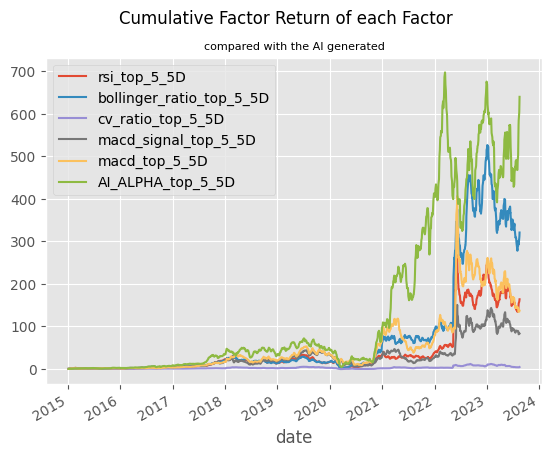

In [221]:
# # * cumulative return
period = '5D'
period_col = [c for c in top_n_return_df if period in c]
top_n_return_df[period_col].add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

<h1 style="color:turquoise">Predict future return and select Top N</h1>

In [248]:
predict_df.tail(2)

,,rsi,stochastic_rsi_k,stochastic_rsi_d,macd,macd_signal,vol_change_pct,overnight_return,cv_ratio,bollinger_ratio,forward_return_5_day,...,sector_industrial,sector_infrastructure,sector_insurance,sector_material,sector_petrochemistry,sector_real_estate,sector_utilities,sector_nan,month,day_of_week
date,ticker,,,,,,,,,,,,,,,,,,,,,
2023-08-23,WHA,90.0,1.0,0.991878,0.096201,0.071221,-0.424778,0.019231,2.372755e-09,1.045195,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,2
2023-08-24,WHA,90.0,1.0,1.000000,0.103242,0.077625,-0.849281,0.000000,5.855450e-09,0.963857,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,3


In [268]:
forward_pred = clf.predict_proba(predict_df.drop(return_col_name, axis=1))
forward_pred_df = pd.DataFrame(forward_pred[:, 1], index=predict_df.index, columns=['score'])

forward_pred_df['period_rank'] = forward_pred_df.groupby(forward_pred_df.index.get_level_values(0))['score'] \
                                    .rank(method='min', ascending=False)
forward_pred_df['top_score'] = forward_pred_df.apply(lambda row: row['score'] if row[f'period_rank'] <= TOP_N else 0, axis=1)
top_df = forward_pred_df[forward_pred_df['top_score'] > 0.0].reset_index() \
            .sort_values(by=['date', 'period_rank']).reset_index(drop=True)
top_df.tail(35)

,date,ticker,score,period_rank,top_score
33,2023-08-23,SPA,0.466538,5.0,0.466538
34,2023-08-23,SYNEX,0.466538,5.0,0.466538
35,2023-08-23,TU,0.466538,5.0,0.466538
36,2023-08-24,EA,0.466538,1.0,0.466538
37,2023-08-24,IVL,0.466538,1.0,0.466538
38,2023-08-24,RATCH,0.466538,1.0,0.466538
39,2023-08-24,AMATA,0.466534,4.0,0.466534
40,2023-08-24,AOT,0.466534,4.0,0.466534
41,2023-08-24,AP,0.466534,4.0,0.466534
42,2023-08-24,BCH,0.466534,4.0,0.466534


In [250]:
TOP_N

5

<h1 style="color:turquoise">Use No Overlap Voter to generate an AI-based Alpha Factor</h1>

In [34]:
n_stocks = len(sector_mapper_available)
n_days = len(x_train)

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 100,
    'min_samples_split': 100,
    'max_depth': 4,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 42}
n_trees_l = range(5, 55, 5)

scores = []
feature_importances = []

for n_trees in n_trees_l:
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf_nov = NoOverlapClassifier(estimator = clf)
    clf_nov.fit(x_train, y_train)
    scores.append({
        'n_tree': n_trees,
        'train': clf_nov.score(x_train, y_train.values),
        'valid': clf_nov.score(x_test, y_test.values),
        'oob': clf_nov.oob_score_
    })

score_df = pd.DataFrame.from_dict(scores) \
            .set_index('n_tree')

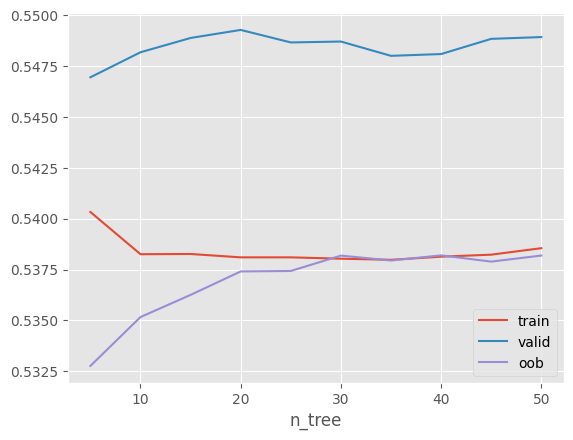

In [35]:
score_df.plot()
plt.legend(loc='best')

In [36]:
# # TODO: choose the best model
N_TREE = 40
clf_best = RandomForestClassifier(N_TREE, **clf_parameters)
clf_nov_best = NoOverlapClassifier(estimator=clf_best)
clf_nov_best.fit(x_train, y_train)

NoOverlapClassifier(estimator=RandomForestClassifier(criterion='entropy',
                                                     max_depth=4,
                                                     min_samples_leaf=100,
                                                     min_samples_split=100,
                                                     n_estimators=40, n_jobs=-1,
                                                     oob_score=True,
                                                     random_state=42))

In [37]:
prob_array = np.array([-1, 1])
proba = clf_nov.predict_proba(x_train)
alpha_score = proba.dot(prob_array)

In [38]:
factors = ['rsi', 'bollinger_ratio', 'cv_ratio', 'macd_signal', 'macd']
alpha_score_label = 'AI_ALPHA'
factors_with_alpha = df.loc[x_train.index].copy()
factors_with_alpha[alpha_score_label] = alpha_score
selected_factor_df = factors_with_alpha[factors + [alpha_score_label]]
selected_factor_df.head(3)

,,rsi,bollinger_ratio,cv_ratio,macd_signal,macd,AI_ALPHA
date,ticker,,,,,,
2015-01-05,AEONTS,35.714400,0.110593,0.000007,0.584415,-0.060833,-0.020885
2015-01-06,AEONTS,33.333357,0.166329,0.000014,0.431636,-0.179480,-0.037210
2015-01-07,AEONTS,25.000020,0.224731,0.000014,0.297455,-0.239269,-0.031938


In [39]:
alpha_eval = AlphaFactorEvaluator(factor_return=selected_factor_df, price=close_df_pivot)
factor_data_dict = alpha_eval.combine_factor_forward_returns(period = 1, max_loss = 0.4, verbose = True)

Formatting factor data for rsi
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for bollinger_ratio
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for cv_ratio
Dropped 0.5% entries from factor data: 0.0% in forward returns computation and 0.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for macd_signal
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Formatting factor data for macd
Dropped 0.0% entries from facto

In [40]:
# factor_data_dict.keys()
# save results
for factor, value_df in factor_data_dict.items():
    value_df.to_csv(f'./test/alphalens/factor_exposure_{factor}.csv')

In [38]:
factor_return_df = alpha_eval.get_factor_returns(factor_data_dict)

In [ ]:
# # save result
# factor_return_df.to_csv('./test/alphalens/factor_return_df.csv')

Text(0.5, 1.0, 'compared with the AI generated')

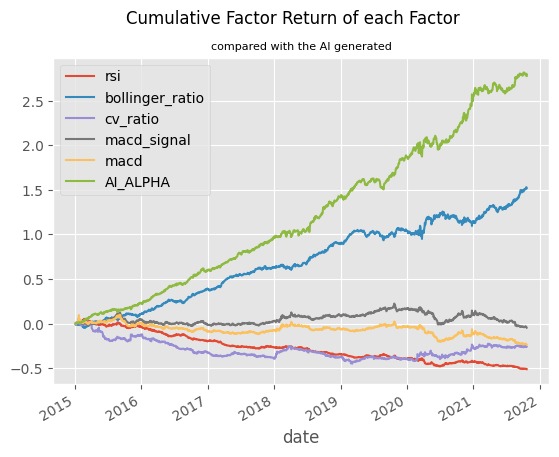

In [ ]:
factor_return_df.add(1).cumprod().add(-1).plot()
plt.suptitle('Cumulative Factor Return of each Factor', size = 12)
plt.title('compared with the AI generated', size = 8)

In [ ]:
# mean return by quantile
qt_return_df = alpha_eval.get_mean_return_by_quantile(factor_data_dict)

In [ ]:
# qt_return_df.to_csv('./test/alphalens/mean_return_by_quantile.csv')

<AxesSubplot: xlabel='factor_quantile'>

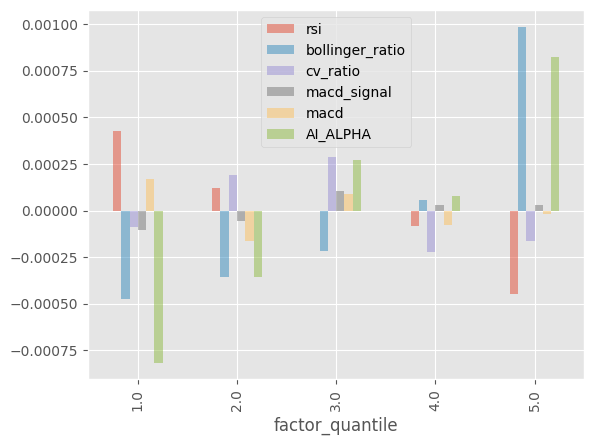

In [ ]:
qt_return_df.plot(kind = 'bar', alpha = 0.5)